### Singel LLM Call

A simple chatbot that responds to user queries (could be used for translation or summarization purposes)

In [1]:
from typing import Annotated, TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI

In [2]:
class State(TypedDict):
    messages : Annotated[list, add_messages]

model = ChatOpenAI()

In [3]:
def chatbot(state: State):
    answer = model.invoke(state["messages"])
    return {"messages": [answer]}

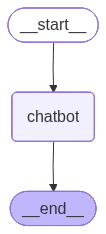

In [4]:
builder = StateGraph(State)
builder.add_node('chatbot', chatbot)
builder.add_edge(START, 'chatbot')
builder.add_edge('chatbot', END)
graph = builder.compile()
graph

In [5]:
from langchain_core.messages import HumanMessage

input = {"messages": [HumanMessage(content='Hi!')]}
graph.invoke(input)

{'messages': [HumanMessage(content='Hi!', additional_kwargs={}, response_metadata={}, id='fc7e97d8-9aad-484b-8f98-c4ddecd7a7ed'),
  AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 9, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Cn5C249TOA8LI2PSARRThqaA0yGaC', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--c91e0d54-4cc3-43f7-bd6f-3efdf32141e3-0', usage_metadata={'input_tokens': 9, 'output_tokens': 9, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [7]:
for chunk in graph.stream(input):
    print(chunk)

{'chatbot': {'messages': [AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 9, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Cn5Cb6czmgcIzYsjasRvZyIXjgz13', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--6c0d2ea0-e054-4a85-8f18-45a1929ddc8d-0', usage_metadata={'input_tokens': 9, 'output_tokens': 9, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}}


### Chaining LLM calls together

Here we'll be using multiple LLM calls, in a predefined sequence.

One LLM call to generate a SQL query from the natural language query, provided by the user, and a description of the database contents and another LLM call to write an explanation of the query appropriate for a nontechnical user, given the query generated in the previous call.

In [20]:
from langchain_core.messages import SystemMessage

# a low temperature model to generate SQL query
low_model = ChatOpenAI(temperature=0.1)

# a high temperature model to generate query summary
high_model = ChatOpenAI(temperature=0.7)

In [21]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    # input
    user_query: str
    # output
    sql_query: str
    sql_explanation: str

class Input(TypedDict):
    user_query: str

class Output(TypedDict):
    sql_query: str
    sql_explanation: str

In [22]:
generate_prompt = SystemMessage("""You are a helpful data analyst who generates SQL queries for users based
 on their questions.""")

In [27]:
def generate_sql(state: State) -> State:
    user_message = HumanMessage(state["user_query"])
    messages = [generate_prompt, *state['messages'], user_message]
    res = low_model.invoke(messages)
    return {
        "sql_query": res.content,
        # update conversation history
        "messages": res,
    }

In [28]:
explain_prompt = SystemMessage(
 "You are a helpful data analyst who explains SQL queries to users."
)

def explain_sql(state: State) -> State:
    sql = state["sql_query"]
    messages = [
        explain_prompt,
        # pass the SQL query from prev step
        HumanMessage(f"Explain this sql query:\n{sql}")
    ]
    res = high_model.invoke(messages)
    return {
        "sql_explanation": res.content,
        # update conversation history only with result of the user_query
        "messages": res,
    }

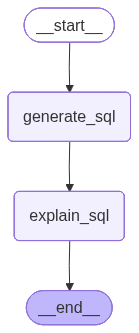

In [29]:
builder = StateGraph(State, input_schema=Input, output_schema=Output)
builder.add_node("generate_sql", generate_sql)
builder.add_node("explain_sql", explain_sql)
builder.add_edge(START, 'generate_sql')
builder.add_edge('generate_sql', 'explain_sql')
builder.add_edge('explain_sql', END)
graph = builder.compile()
graph

In [30]:
graph.invoke({
 "user_query": "What is the total sales for each product?"
})

{'sql_query': 'To calculate the total sales for each product, you can use the following SQL query:\n\n```sql\nSELECT product_name, SUM(sales_amount) AS total_sales\nFROM sales_data\nGROUP BY product_name;\n```\n\nThis query will group the sales data by product name and calculate the total sales amount for each product.',
 'sql_explanation': 'This SQL query selects the product name and calculates the total sales amount for each product from the `sales_data` table. It uses the `SUM()` function to sum up the `sales_amount` column for each product. \n\nThe `GROUP BY product_name` clause groups the data by the `product_name` column, so the `SUM()` function calculates the total sales amount for each unique product name. This query will return a list of product names along with their corresponding total sales amounts.'}